<style>
/* Reveal container full viewport */
.reveal {
  width: 95vw !important; /* 95% of view width */
  height: 50vw !important;   /* about 16:9 aspect ratio height (width × 9/16) */
  max-width: 95vw !important;
  max-height: 50vw !important;
  margin: auto;
  font-size: 110%; /* global font size */
}

/* Slides filling container */
.reveal .slides {
  width: 100% !important;
  height: 100% !important;
  max-width: 100% !important;
  max-height: 100% !important;
  margin: auto;
  overflow-wrap: break-word;
}

/* Prevent content from overflowing horizontally */
.reveal section {
  overflow-x: auto;
  word-wrap: break-word;
  box-sizing: border-box;
  padding: 1em;
}

/* Tables scroll horizontally if too wide */
.reveal section table {
  display: block;
  overflow-x: auto;
  white-space: nowrap;
  max-width: 100%;
  margin: 0 auto;
  font-size: 90%;
  border-collapse: collapse;
}

/* Smaller font and compact padding inside table cells */
.reveal section table td,
.reveal section table th {
  font-size: 90%;
  padding: 0.3em 0.5em;
  white-space: nowrap;
}
</style>

# Third Hands-On Session
---
Exploring periodic lattices:

- Implementing and studying the properties of a FODO cell/lattice
- Computing closed optics solutions
- The concept of Tune and FODO cell phase advance
- Introducing Sector Bends
---

## 🐍 Python corner

Let's import standard packages and settings. We'll be using:
- `numpy` as `np`
- `matplotlib.pyplot` as `plt`
- `from ipywidgets import interactive`
- functions `D`, `Q`, `transportParticles`, `getEquivalentElement`

In [1]:
# Import custom tracking functions and useful libraries
from tracking_library import *

numpy is installed, version: 2.3.1
scipy is installed, version: 1.15.3
matplotlib is installed, version: 3.10.0
-> Setup is OK! Have fun!


## ⚛️ Physics focus: From arbitrary transport to periodic transport

From the previous lecture we know that any beam line can be described by a transfer matrix M. In a periodic system (e.g. an accelerator ring), the beam passes through the same structure repeatedly, so after m turns:
\begin{equation}
X_m = M \cdot M \cdot ... \cdot M X_0 = M^m X_0
\end{equation}
where M is the transfer matrix of one full period, also called **the One-Turn Map (OTM)**. 

For the motion to be stable over many turns, the particle trajectory must remain bounded:
\begin{equation}
|X_m| < |\hat{X}| \qquad  \forall \quad X_0, m
\end{equation}
For a 2x2 real symplectic matrix (such as M), this stability condition translates into a simple requirement on the trace:
\begin{equation}
\frac{1}{2}|Tr(M)|\leq1
\end{equation}

**In the following, we will study particle motion and stability using one of the most common periodic structures: the FODO cell!**


## 📝 Exercise 3.1: Stability of the FODO cell

The FODO cell is one of the most fundamental lattice topologies. In its simpler version, it consists on two thin quadrupoles of opposite focal length, f, spaced by two drifts of length $L$ (as in [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/)), i.e. the total length of the cell ($L_{FODO}$) is $2L$. 

<p align="center">
<img src=./_img_exercises/slide_fodo.png width="60%">
</p>

1. Define a **FODO beamline** that **starts and ends in the middle of a focusing quadrupole** (we could start the FODO from an arbitrary point inside it). For the moment, we can define arbitrarily the $f$ and $L$ parameters: we chose **2.5 m and 1 m**, respectively.

> 👀 **HINT 1**: A half-quadrupole has double the focal length than a full quadrupole.

> 👀 **HINT 2**: To better visualize the trajectory of the particle(s), always split the drifts in several shorter drifts (e.g. $10$ drifts, each $L/10$ long).
    
2. Track a particle that has an initial offset $x = 1$ mm and no angle $x' = -0.1$ mrad, and plot its position $x$ and angle $x'$ along the beam line.

> 👀 **HINT 3**: After having plotted $x$ trajectory on a plot, one can create a second vertical axis that shares the same horizontal axis with `plt.twinx()`

3. Plot the position $x$ and angle $x'$ through $N=100$ equal FODO cells.

4. Play with different values of the focal length $f$ and explore whether you can make the oscillations grow.

> 👀 **HINT 4**: Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/): the stability of a FODO cell takes the form:
> \begin{equation}
    \frac{1}{2}|Tr(M)| = \left|\frac{L}{2f}\right| = \left|\frac{L_{FODO}}{4f}\right| \leq 1
   \end{equation}

### Solution for 1. 

In [2]:
f = 2.5
L = 1
beamline = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)

### Solution for 2.

(-0.5, 0.5)

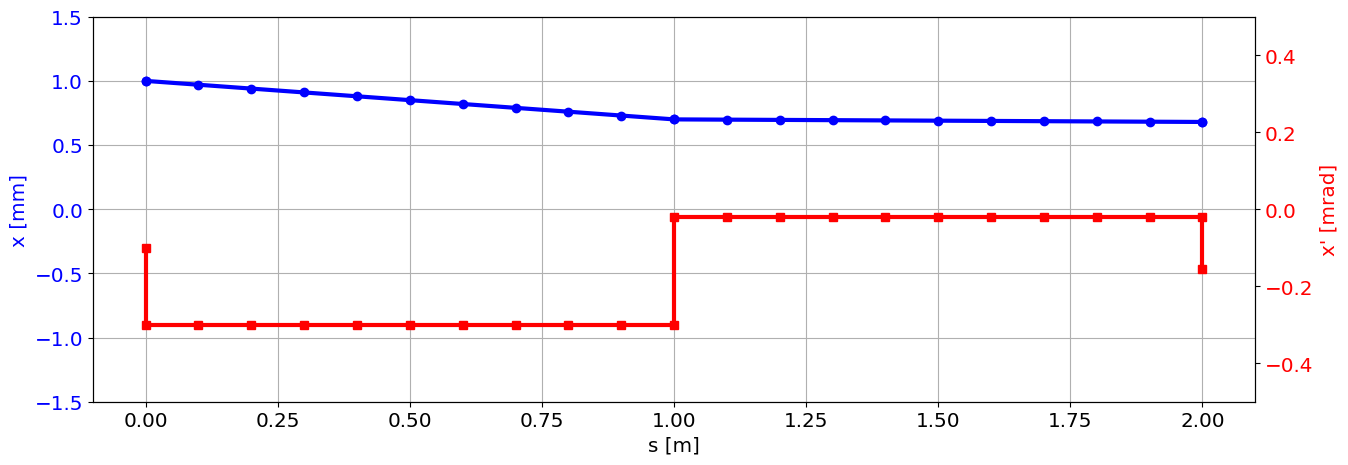

In [3]:
X_0 = np.array([ [1], 
                 [-0.1] ])

# do tracking
transported_particles = transportParticles(X_0, beamline)

# plotting
plt.plot(transported_particles["s"], transported_particles["x"], "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("x [mm]", color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.ylim([-1.5, 1.5])

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.tick_params(axis="y", labelcolor="r")
plt.plot(transported_particles["s"], transported_particles["xp"], "s-r", lw=3)
plt.ylabel("x' [mrad]", color="r")
plt.ylim([-0.5, 0.5])

### Solution for 3. 

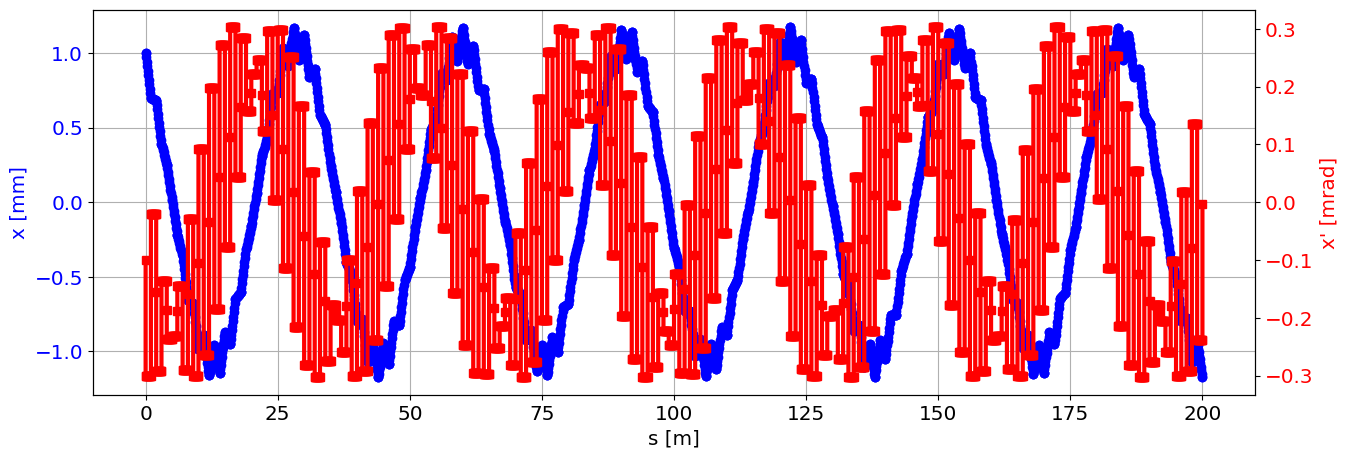

In [4]:
transported_particles = transportParticles(X_0, 100 * beamline)

plt.plot(transported_particles["s"], transported_particles["x"], "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("x [mm]", color="b")
plt.tick_params(axis="y", labelcolor="b")

# instantiate a second axes that shares the same x-axis
ax2 = plt.twinx()
plt.ylabel("x' [mrad]", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(transported_particles["s"], transported_particles["xp"], "s-r", lw=3)

### Solution for 4. 

In [5]:
# Check stability interactively
def plot_function(f, L):
    # prepare the tracking
    beamline = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
    X = np.array([[1], [-0.1]])
    transported_particles = transportParticles(X_0, 100 * beamline)

    plt.plot(transported_particles["s"], transported_particles["x"], "o-b", lw=3)
    plt.grid(True)
    plt.xlabel("s [m]")
    plt.ylabel("x [mm]", color="b")
    plt.tick_params(axis="y", labelcolor="b")
    ax2 = plt.twinx()
    plt.ylabel("x' [mrad]", color="r")
    plt.tick_params(axis="y", labelcolor="r")
    plt.plot(transported_particles["s"], transported_particles["xp"], "s-r", lw=3)

interactive_plot = interactive(plot_function, f=(0.1, 10, 0.01), L=(0, 2, 0.1), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

interactive(children=(FloatSlider(value=5.05, description='f', max=10.0, min=0.1, step=0.01), FloatSlider(valu…

## 📝 Exercise 3.2: Transport of sigma matrix in a FODO beamline & searching periodic solution

1. Transport a sigma matrix (e.g. $\beta$ = 3 [m], $\gamma$ = 0.5 [1/m], $\epsilon$ = 1 [mm mrad]) through a beamline made of 8 FODO cells (with, for example, $f=2.5$ and $L=1$ as before), and plot the evolution of the sigma matrix elements ($\sigma_{xx}$, $\sigma_{x'x'}$, $\sigma_{xx'}$) along the beamline. Do you see a periodic structure?

2. Try to vary the initial sigma matrix parameter by **try and error** that reproduces itself at the end of the beam line (8 FODO cells), meaning:

   \begin{equation}
      \Sigma_{0} = M_{\mathrm{OTM}} \Sigma_0 M_{\mathrm{OTM}}^T
   \end{equation}
    You will quickly realise that this is extremely difficult if not impossible. 
    > 👀 **HINT 1**: (optional) you might want to use an **interactive plot** - see in the previous exercise how to make one

### Solution for 1.

Text(0, 0.5, "$\\sigma_{xx'} = -\\epsilon \\cdot \\alpha $")

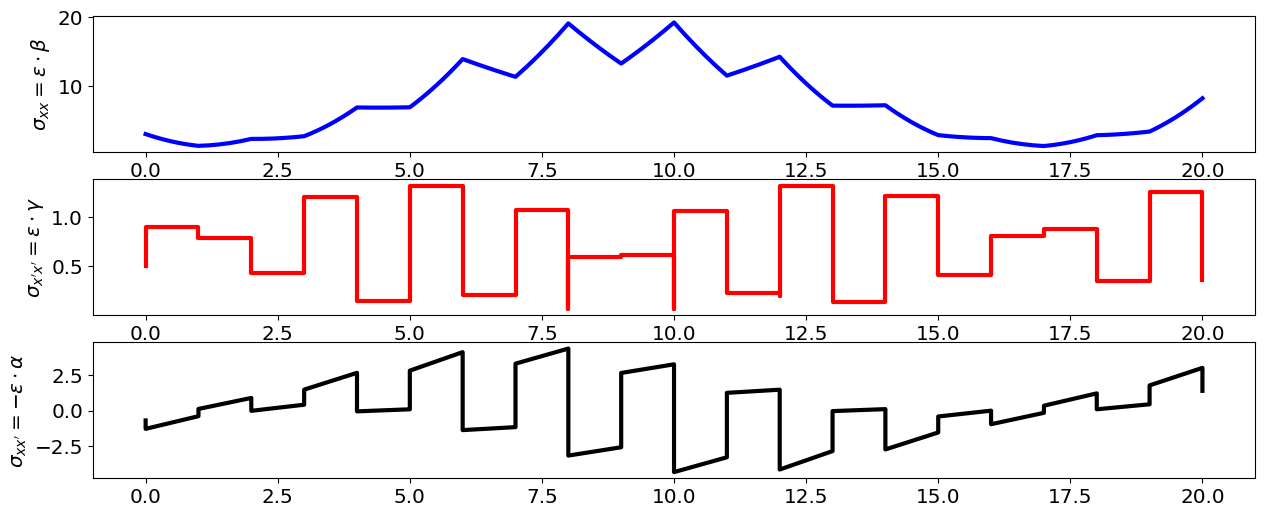

In [6]:
f = 2.5
L = 1
fodo_cell = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
fodo_lattice = 10 * fodo_cell

# define the initial sigma matrix
beta0 = 3 
gamma0 = 0.5
epsilon0 = 1
# alfa must be:
alfa0 = np.sqrt(beta0 * gamma0 - 1)
sigma_0 = epsilon0 * np.array([ [beta0, -alfa0], 
                                [-alfa0, gamma0] ])

# transport the sigma matrix:
transported_sigmas = transportSigmas(sigma_0, fodo_lattice)
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.plot(transported_sigmas["s"], transported_sigmas["sigma11"], "-b", lw=3)
plt.ylabel(r"$\sigma_{xx} = \epsilon \cdot \beta $")
plt.subplot(312)
plt.plot(transported_sigmas["s"], transported_sigmas["sigma22"], "-r", lw=3)
plt.ylabel(r"$\sigma_{x'x'} = \epsilon \cdot \gamma $")
plt.subplot(313)
plt.plot(transported_sigmas["s"], transported_sigmas["sigma12"], "-k", lw=3)
plt.ylabel(r"$\sigma_{xx'} = -\epsilon \cdot \alpha $")

### Solution for 2. 

In [7]:
def plot_function(sigmaxx, sigmaxpxp, sigmaxxp):
    # prepare the sigma matrix
    sigma0 = np.array([[sigmaxx, sigmaxxp], [sigmaxxp, sigmaxpxp]])

    output_b = transportSigmas(sigma0, fodo_lattice)
    plt.figure(figsize=(15, 6))
    plt.subplot(311)
    plt.plot(output_b["s"], output_b["sigma11"], "-b", lw=3)
    plt.ylabel(r"$\sigma_{xx} = \epsilon \cdot \beta $")
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b["s"], output_b["sigma22"], "-r", lw=3)
    plt.ylabel(r"$\sigma_{x'x'} = \epsilon \cdot \gamma $")
    plt.grid(True)
    plt.subplot(313)
    plt.plot(output_b["s"], output_b["sigma12"], "-k", lw=3)
    plt.ylabel(r"$\sigma_{xx'} = -\epsilon \cdot \alpha $")
    plt.grid(True)

interactive_plot = interactive(plot_function, sigmaxx=(10, 20, 0.1), sigmaxpxp=(0, 4, 0.1), sigmaxxp=(-5, 5, 0.1), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

# **approximate** solution found by hand:
#plot_function(15.5, 0.4, 0)

interactive(children=(FloatSlider(value=15.0, description='sigmaxx', max=20.0, min=10.0), FloatSlider(value=2.…

## ⚛️ Physics focus: Periodic solution (matching)

For a **stable lattice**, there must exist a **periodic solution**. In other words, there are Twiss parameters such that the beam matrix reproduces itself after one turn:

\begin{equation}
  \Sigma_{0} = M_{\mathrm{OTM}} \Sigma_0 M_{\mathrm{OTM}}^T
\end{equation}

Using the Twiss parametrization, the periodic solution is (**recall** [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/)):

\begin{equation}
    M_{\mathrm{OTM}} = 
        \left[
        \begin{array}{cc}
        \cos(\mu) + \alpha_0 \sin(\mu)  & \beta_0 \sin(\mu)\\
        - \gamma_0 \sin(\mu) & \cos(\mu) - \alpha_0 \sin(\mu)
        \end{array}
        \right]
        =
        \left[
        \begin{array}{cc}
        r_{11}  & r_{12} \\
        r_{21}  & r_{22}
        \end{array}
        \right]
\end{equation}

Here, $\alpha_0$, $\beta_0$, and $\gamma_0$ are the Twiss parameters at the start (or equivalently the end) of the lattice, and $\mu$ is the **phase advance**. The total phase advance around the ring, divided by $2\pi$, is called the **tune**.

The important point is that the existence of **these periodic Twiss parameters is a property of the lattice itself**: they depend only on its focusing structure (e.g. quadrupole strength $f$, drift length $L$), not on the initial beam distribution.

Of course, in practice one can inject a mismatched beam, meaning **a beam whose Twiss parameters do not coincide with the periodic solution of the lattice**. In this case the motion remains stable, but the beam size and particle oscillations can vary significantly along the lattice and from turn to turn.

## 📝 Exercise 3.3: Periodic solution of a FODO cell

Remember [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/) for finding the periodic solution:

<p align="center">
<img src=./_img_exercises/slide_fodo_periodic.png width="60%">
</p>

**Get the one turn matrix of a FODO cell using the `getEquivalentElement` function and extract the matching initial conditions.** 

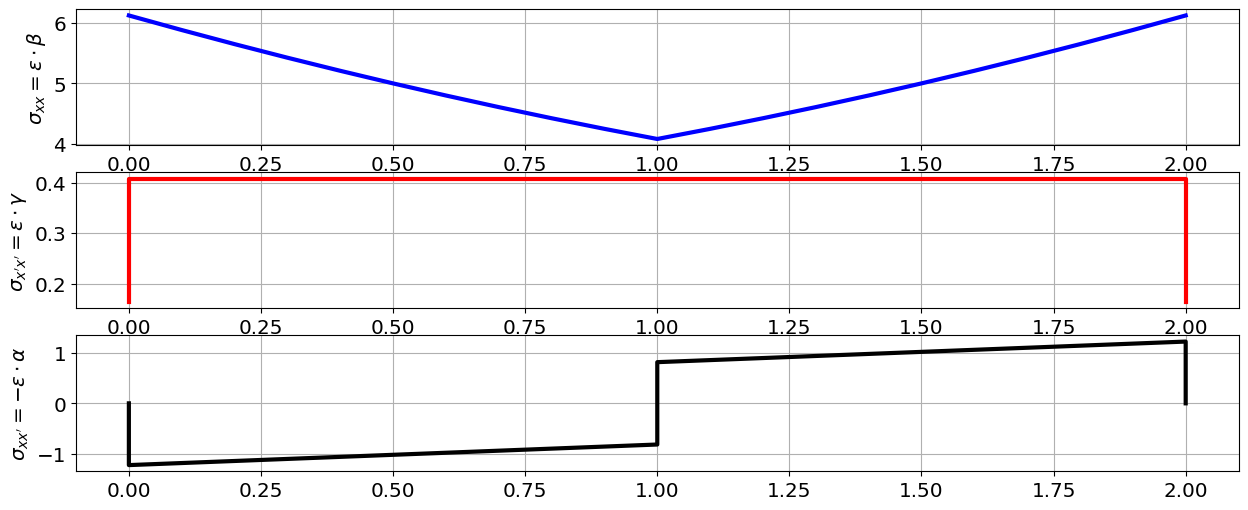

In [8]:
# get the one turn matrix:
f = 2.5
L = 1
fodo_cell = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
fodo_cell_OTM = getEquivalentElement(fodo_cell)[0]["matrix"]

# extract the matched initial conditions
beta0 = fodo_cell_OTM[0, 1] / np.sqrt(1 - (fodo_cell_OTM[0, 0]) ** 2)
gamma0 = 1 / beta0
alpha0 = 0
mu = np.arccos(fodo_cell_OTM[0, 0])

# The matched beam would be the one with :
sigmaxx = beta0 * 1 # assuming emittance of one
sigmaxpxp = gamma0 * 1 # assuming emittance of one
sigmaxxp = 0

sigma0 = np.array([ [sigmaxx, sigmaxxp], 
                    [sigmaxxp, sigmaxpxp] ])

output_b = transportSigmas(sigma0, fodo_cell)
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.plot(output_b["s"], output_b["sigma11"], "-b", lw=3)
plt.ylabel(r"$\sigma_{xx} = \epsilon \cdot \beta $")
plt.grid(True)
plt.subplot(312)
plt.plot(output_b["s"], output_b["sigma22"], "-r", lw=3)
plt.ylabel(r"$\sigma_{x'x'} = \epsilon \cdot \gamma $")
plt.grid(True)
plt.subplot(313)
plt.plot(output_b["s"], output_b["sigma12"], "-k", lw=3)
plt.ylabel(r"$\sigma_{xx'} = -\epsilon \cdot \alpha $")
plt.grid(True)

### 🔹 **NOTE** Those concepts are implemented in the function `twiss()` from our toolbox:

In [9]:
from tracking_library import twiss

help(twiss)

Help on function twiss in module tracking_library:

twiss(beamline)
    Compute Twiss parameters and tune for a periodic beamline.

    Parameters
    ----------
    beamline : list of dict
        Sequence of beamline elements.

    Returns
    -------
    tune : float
        Betatron tune (fraction of oscillation per turn).
    beta : float
        Beta function at entrance [m].
    alpha : float
        Alpha function at entrance.
    gamma : float
        Gamma function at entrance.



> 🔹 **NOTE**: We can apply this function to any beamline, e.g. a series of quadrupoles and drifts, e.g.:

In [10]:
# create a random beamline of many elements
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + 10 * D(1.5 / 10))

# compute the closed solution
(tune, beta, alpha, gamma) = twiss(beamline)
print(tune, beta, alpha, gamma)

# assemble the sigma matrix
epsilon = 1
sigma_matrix = np.array([ [beta, -alpha], 
                          [-alpha, gamma]]) * epsilon

# print out the values
print(f"The total phase advance (or tune) of the beamline is {tune}.")
print(f"The sigma matrix is:\n {sigma_matrix}")
print(f"which has determinant equal to: {np.linalg.det(sigma_matrix):.3f}.")

0.5999038489602736 16.98880317145331 -14.570921072145396 12.556019322722127
The total phase advance (or tune) of the beamline is 0.5999038489602736.
The sigma matrix is:
 [[16.98880317 14.57092107]
 [14.57092107 12.55601932]]
which has determinant equal to: 1.000.


## 📝 Exercise 3.4: Tuning FODO phase advance

The Twiss parameters and the phase advanced can be 'tuned' by changing the focusing and length of our FODO cell. Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/) and see that (with some math), one can prove that:

\begin{equation}
       \sin(\mu/2) = \frac{L_{FODO}}{4f}
\end{equation}

Consider a single FODO cell of total length $L_{FODO}=2$ m. **Can you find $f$ such that the FODO cell phase advance is $\mu = \pi/2$, i.e. 90 deg phase-advance?**

> Optional/guided: Introduce **sector bends** ($L_{bend} = L/2 = 0.5$ m, and bending angle $\phi=10$ degrees) in the middle of both drifts of the FODO cell, without changing the total length of the FODO cell. How does the optics change?

> 👀 **HINT**: Our toolbox library implements also sector bends: `B(phi, L)` defined by bending angle (`phi`) and bend lenght (`L`).

In [11]:
# let's build up the FODO cell using the provided inputs
L_FODO = 2
desired_mu = np.pi / 2
f = L_FODO / (4 * np.sin(desired_mu / 2))
L = L_FODO / 2

# fodo starting from the middle of a quad
fodo_lattice_1 = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
# or drift (equivalent)
#fodo_lattice_2 = 5 * D(L / 10) + Q(f) + 10 * D(L / 10) + Q(-f) + 5 * D(L / 10)

tune, beta, alpha, gamma = twiss(fodo_lattice_1)
print(f"Fodo starting in the quad: tune is {tune}.")
print(f"Alpha={alpha}, beta={beta}, gamma={gamma}.")
#tune, beta, alpha, gamma = twiss(fodo_lattice_2)
#print(f"Fodo starting in the drift: tune is {tune}.")

Fodo starting in the quad: tune is 0.24999999999999986.
Alpha=2.449993326556931e-17, beta=3.414213562373094, gamma=0.29289321881345254.


### Solution of optional

In [12]:
from tracking_library import B

bend_angle = 20 * np.pi/180

# Reproduce the beamline with bends (splitting bends in a few pieces, just to have more points in the plots...)
fodo_cell_bend = (
      Q(2 * f)
    + D(L/4)
    + B(bend_angle/2, L/2)
    + D(L/4) 
    + Q(-f)
    + D(L/4)
    + B(bend_angle/2, L/2)
    + D(L/4) 
    + Q(2 * f)
)

tune, beta, alpha, gamma = twiss(fodo_cell_bend)
print(f"Fodo starting in the quad: tune is {tune}.")
print(f"Alpha={alpha}, beta={beta}, gamma={gamma}.")

Fodo starting in the quad: tune is 0.26464657812711273.
Alpha=-1.8117789792320428e-16, beta=3.3014028208445403, gamma=0.3029015404258325.


> 🔹 **NOTE:** the optics has changed, so the tune. Why? Extra-focusing from sector bends...

## 📝 Exercise 3.5: Putting it all together — tuning an accelerator ring and tracking a beam

1. **Build the synchrotron.** 
   - Construct a synchrotron of total length 160 m, composed of 16 FODO cells (ignore dipoles; start at the center of a focusing quadrupole).  
   - Determine the quadrupole strength required to obtain a phase advance of 60.12 degrees per cell.  
   - Compute the one-turn matrix (OTM) of the synchrotron and verify that the lattice is stable.  
   - Find the Twiss parameters of the periodic solution and calculate the tune. Check that the phase advance per cell is indeed close to 60 degrees.
2. **Generate a matched Gaussian beam and plot beta function**  
   - Using the Twiss parameters from step 1 and an emittance of **1 mm·mrad**, compute the **sigma matrix** and the corresponding beam size. Compute the beta function along the ring by tracking the sigma matrix.   
   - Generate **500 particles** with $<x_0>$ = 0, $<x'_0>$ = 0, and second moments given by the sigma matrix (i.e. $\sigma_{xx}$, $\sigma_{x'x'}$, $\sigma_{xx'}$).  
   - Plot the **initial phase space distribution** of the particles.
3. **Track the beam for one turn**  
   - Track all 500 particles for **one full turn**.  
   - In a single figure, plot:  
     - all particle trajectories (black),  
     - the trajectory of the first particle (orange),  
     - and the mean trajectory of the beam (blue).
4. **Track a single particle - betatron oscillations, tune and single particle ellipse** 
   - Select a single particle with a chosen $(x_0, x'_0)$ and track it for **100 turns** (use a loop).  
   - Plot its trajectory and its trace space evolution turn by turn.
   - Optional: use interactive plotting for varying the number of turns  

### Solution for 1. 

In [13]:
# Our parameters
Lsynchrotron = 160 # m 
ncells = 16
Lcell = Lsynchrotron/ncells # the length of the FODO cell
L = Lcell/2 # our usual formalism
desired_mu = 60.12 * (np.pi/180) # desired phase advance of 60.12 degrees
#desired_mu = 101.12 * (np.pi/180)
f = Lcell / (4 * np.sin(desired_mu / 2)) # tuning the FODO cell from theory

# Define the synchrotron
fodo_cell = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
synchrotron = fodo_cell * ncells

In [14]:
# Calculate equivalent matrix: 
synchrotron_OTM = getEquivalentElement(synchrotron)[0]['matrix']
trace = synchrotron_OTM[0,0] + synchrotron_OTM[1,1]
print("The absolute value of 0.5*Tr(M) is:", abs(0.5*trace))

The absolute value of 0.5*Tr(M) is: 0.4707039321653379


In [15]:
# Twiss it (find the periodic solution)
tune, beta0, alpha0, gamma0 = twiss(fodo_cell)
mu = tune*(2*np.pi) #/ ncells
print('Tune (per cell), beta0, alpha0, gamma0:', tune, beta0, alpha0, gamma0)
print('Phase advance per cell mu = ', mu*180/np.pi, 'degrees')
print('The tune over one revolution is:', tune*ncells) 

Tune (per cell), beta0, alpha0, gamma0: 0.16699999999999995 17.31008351850625 3.201074096766588e-17 0.057769796369318366
Phase advance per cell mu =  60.11999999999999 degrees
The tune over one revolution is: 2.6719999999999993


### Solution for 2. 

In [16]:
epsilon0 = 1
sigma_0 = epsilon0 * np.array([ [beta0, -alpha0], 
                               [-alpha0, gamma0] ])
sigx = np.sqrt(sigma_0[0,0])
sigxp = np.sqrt(sigma_0[1,1])
print('The beam size is ', sigx, ' mm')
print('The beam divergence is ', sigxp, ' mrad')

The beam size is  4.16053884953695  mm
The beam divergence is  0.24035348212438773  mrad


Text(0.5, 0, 's [m]')

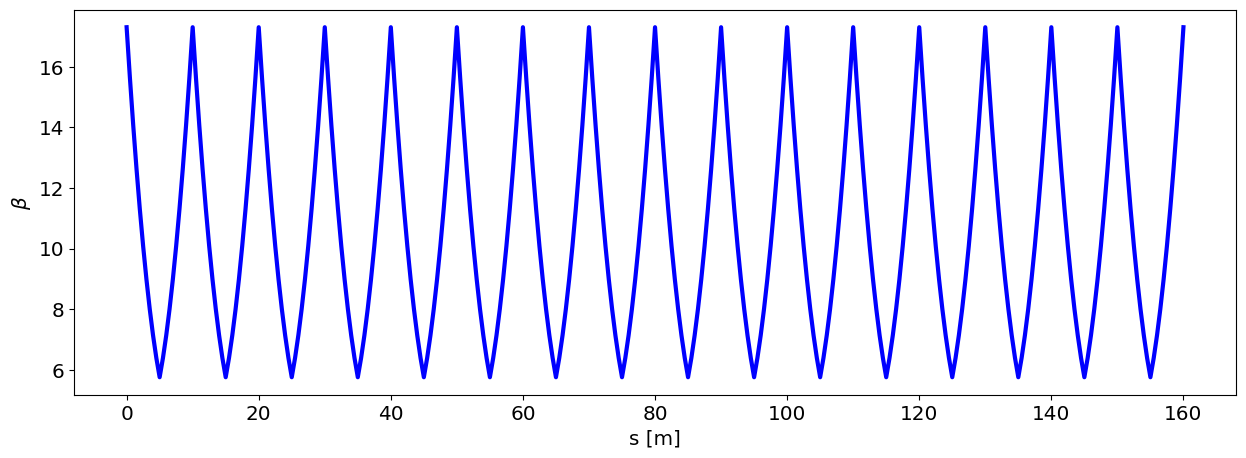

In [17]:
output = transportSigmas(sigma_0, synchrotron)
beta_function = output["sigma11"]/epsilon0
plt.plot(output["s"], beta_function, "-b", lw=3)
plt.ylabel(r"$\beta$")
plt.xlabel('s [m]')

In [18]:
# prepare the beam
N_particles = 4000
beam = np.random.randn(2, N_particles)
x0 = 0
xp0 = 0
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

Text(0, 0.5, "x' [mrad]")

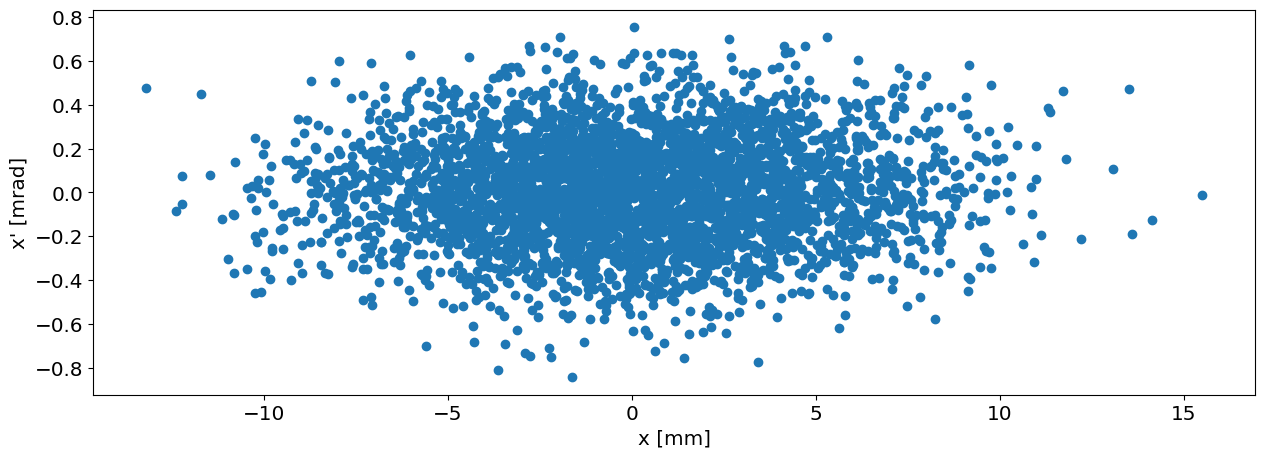

In [19]:
# Phase space
plt.plot(beam[0,:], beam[1,:], 'o')
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")

### Solution for 3. 

In [20]:
# Transport the particles
transported_particles = transportParticles(beam, synchrotron)

In [21]:
# Calculate mean trajectory
mean_trajectory = np.mean(transported_particles["x"], axis=1) # remember axis=1 means average over rows in a 2D matrix

In [22]:
# Get trajectory of the first particle
particle_index = 0
single_particle_trajectory = transported_particles["x"][:,particle_index] # first index -> s-position, second index -> particle

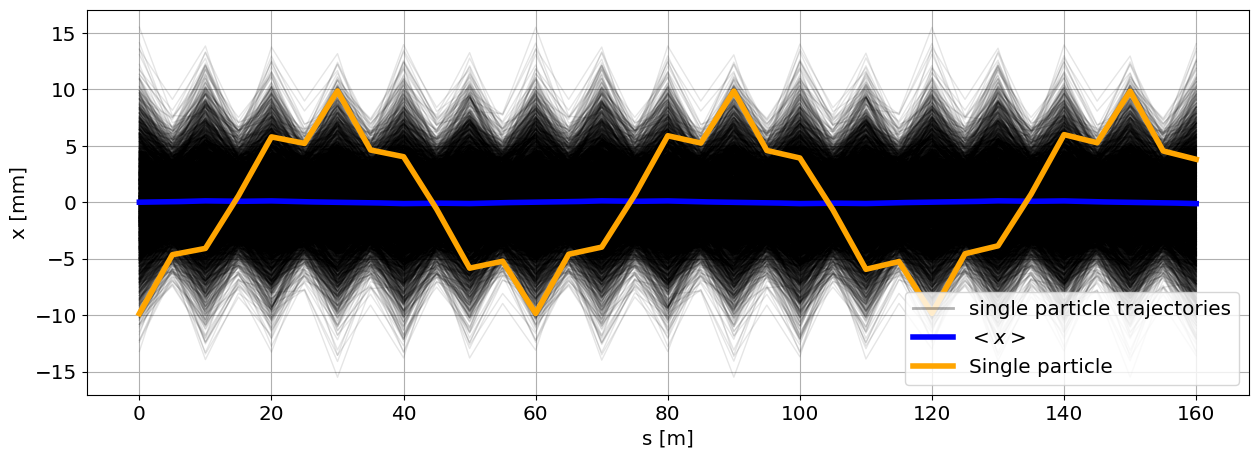

In [23]:
# Plotting
plt.plot(transported_particles["s"], transported_particles["x"], ls="-", color='black', lw=1, alpha=0.1) # individual particle trajectories
plt.plot([],[], ls="-", color='black', lw=2, alpha=0.3, label='single particle trajectories') # dummy plot, for label

plt.plot(transported_particles["s"], mean_trajectory, "-", color='blue', lw=4, label=r'$<x>$') # plotting the mean in blue

plt.plot(transported_particles["s"], single_particle_trajectory, "-", color='orange', lw=4, label=r'Single particle') # plotting a single particle

plt.grid(True)
plt.ylabel("x [mm]")
plt.xlabel("s [m]")
plt.legend()

### Solution for 4. 

In [27]:
# Single particle
X_0 = np.array([ [4],
                 [0.01] ])

In [28]:
# Do the tracking turn by turn
trajectories_turn_by_turn = []
x0_turn_by_turn = []
xp0_turn_by_turn = []
nturns = 100
for turn in range(nturns):
    transported_particle = transportParticles(X_0, synchrotron)

    # save the trajectory for this turn
    trajectories_turn_by_turn.append(transported_particle["x"][:,0])
    x0_turn_by_turn.append(transported_particle["x"][0,0])
    xp0_turn_by_turn.append(transported_particle["xp"][0,0])

    # update the partice coordinates for the next turn
    X_0 = np.array([ [transported_particle["x"][-1,0]],
                     [transported_particle["xp"][-1,0]] ])

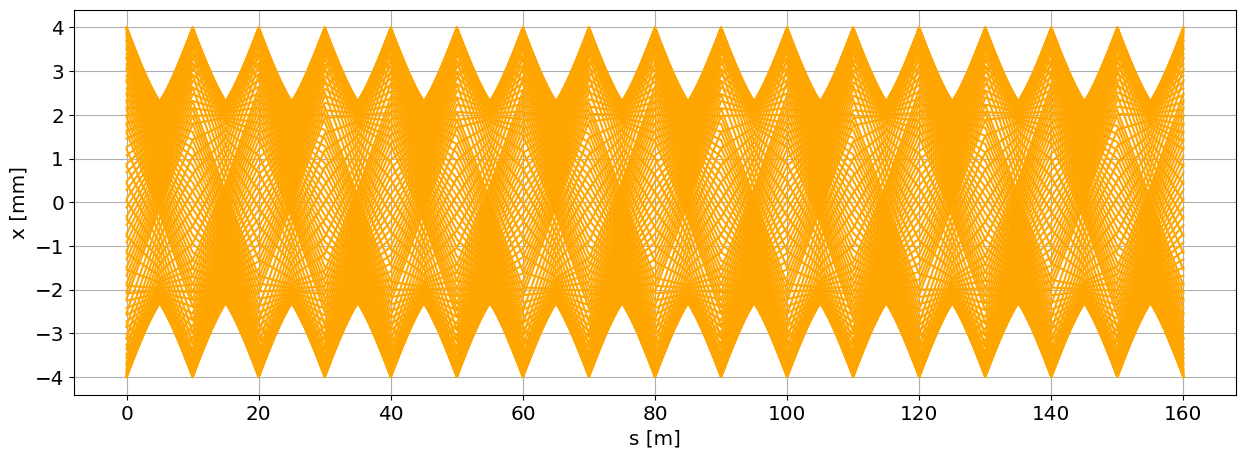

In [29]:
plt.grid(True)
plt.ylabel("x [mm]")
plt.xlabel("s [m]")
for turn in range(nturns):
    plt.plot(transported_particle['s'], trajectories_turn_by_turn[turn], '-', color='orange')

## The particles turn-by-turn perform betatron oscillations. The tune tells us how many oscillations a partcle performs during one revolution. 

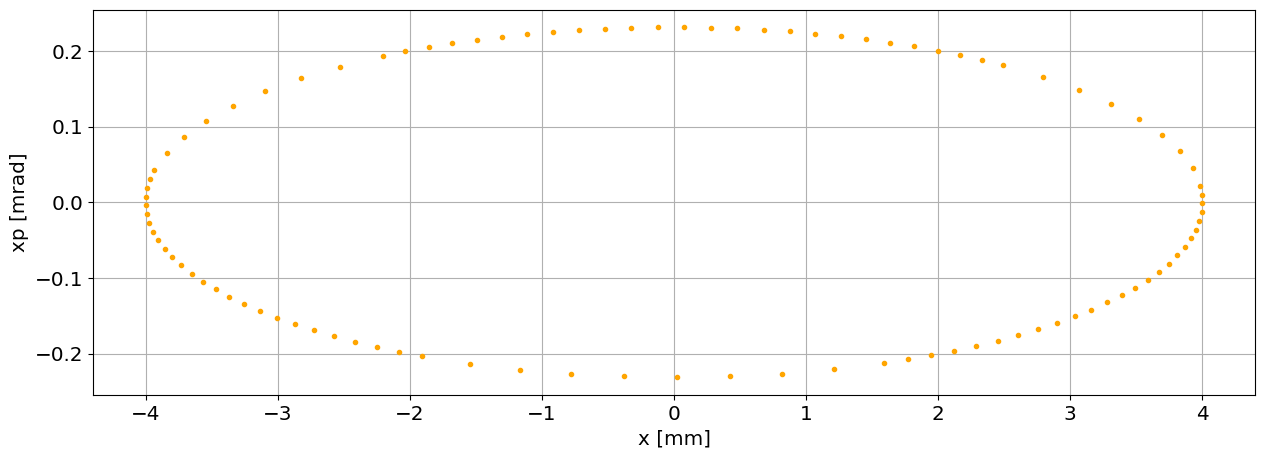

In [30]:
plt.grid(True)
plt.xlabel("x [mm]")
plt.ylabel("xp [mrad]")
plt.plot(x0_turn_by_turn, xp0_turn_by_turn, '.', color='orange')

## In the trace space, the particle motion follows a close loop (ellipse)

In [38]:
# Animation
def plot_function(nturns, f):
    X_0 = np.array([ [2],
                     [0.5] ])
    fodo_cell = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f) # starting at middle of focusing quadrupole
    #fodo_cell = 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(f) # starting after focusing quadrupole 
    synchrotron = fodo_cell * 16

    trajectories_turn_by_turn = []
    x0_turn_by_turn = []
    xp0_turn_by_turn = []
    for turn in range(nturns):
        transported_particle = transportParticles(X_0, synchrotron)
    
        # save the trajectory for this turn
        trajectories_turn_by_turn.append(transported_particle["x"][:,0])
        x0_turn_by_turn.append(transported_particle["x"][0,0])
        xp0_turn_by_turn.append(transported_particle["xp"][0,0])
    
        # update the partice coordinates for the next turn
        X_0 = np.array([ [transported_particle["x"][-1,0]],
                         [transported_particle["xp"][-1,0]] ])


    f, axs = plt.subplots(1,2,figsize=(10,5))
    ax = axs[0]
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('xp [mrad]')
    ax.set_xlim(-10,10)
    ax.set_ylim(-2.5,2.5)
    ax.plot(x0_turn_by_turn, xp0_turn_by_turn, '.', color='blue')
    ax = axs[1]
    ax.set_xlabel('s [m]')
    ax.set_ylabel('x [mm]')
    ax.set_xlim(0,160)
    ax.set_ylim(-15,15)
    for turn in range(nturns):
        ax.plot(transported_particle['s'], trajectories_turn_by_turn[turn], '-', color='blue')
    f.tight_layout()

interactive_plot = interactive(plot_function, nturns=(1, 100, 1), f=(2.5, 30, 0.01), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

interactive(children=(IntSlider(value=50, description='nturns', min=1), FloatSlider(value=16.25, description='…

### 🔹 NOTE: the Twiss parameters get a special meaning

<p align="center">
<img src=./_img_exercises/ellipse.png width="70%">
</p>

## Well done !!

=> **If you still have time, continue your learning with the following [notebook](./04_Dispersion.ipynb)**...
